# Modeling Cross Section Data with Decision Trees and Random Forest

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
sns.set_style("darkgrid")

# Reading Cross Section Data into Dataframe

In [69]:
print("Reading data into dataframe...")
df = pd.read_csv("../ML_Data/working_xs_v1_unsk.csv")
print("Data read into dataframe!")

str_cols = ["Target_Meta_State", "MT", "I78", "Product_Meta_State", "Frame", "Reaction_Notation",
            "Title", "Institute", "Reference", "Out", "Origin", "Element", "Element_w_A", "Flag"]
df[str_cols] = df[str_cols].astype('category')

for col in list(df.columns):
    if col not in str_cols:
        df[col] = df[col].astype(float)
        
int_cols = ["Target_Protons", "Target_Neutrons", "Target_Mass_Number", "Year", "Date", 
            "Compound_Neutrons", "Compound_Mass_Number"]
df[int_cols] = df[int_cols].astype(int)

Reading data into dataframe...
Data read into dataframe!


In [70]:
df.columns

Index(['Target_Meta_State', 'MT', 'Energy', 'dEnergy', 'Data', 'dData', 'I78',
       'Target_Protons', 'Product_Meta_State', 'Frame', 'Reaction_Notation',
       'Title', 'Year', 'Institute', 'Date', 'Reference', 'Out',
       'Target_Neutrons', 'Target_Mass_Number', 'Element', 'Origin',
       'Mass_Excess', 'dMass_Excess', 'Binding_Energy', 'dBinding_Energy',
       'B_Decay_Energy', 'dB_Decay_Energy', 'Atomic_Mass_Micro',
       'dAtomic_Mass_Micro', 'S(2n)', 'dS(2n)', 'S(2p)', 'dS(2p)', 'Q(a)',
       'dQ(a)', 'Q(2B-)', 'dQ(2B-)', 'Q(ep)', 'dQ(ep)', 'Q(B-n)', 'dQ(B-n)',
       'S(n)', 'dS(n)', 'S(p)', 'dS(p)', 'Q(4B-)', 'dQ(4B-)', 'Q(d,a)',
       'dQ(d,a)', 'Q(p,a)', 'dQ(p,a)', 'Q(n,a)', 'dQ(n,a)', 'Q(g,p)', 'Q(g,n)',
       'Q(g,pn)', 'Q(g,d)', 'Q(g,t)', 'Q(g,He3)', 'Q(g,2p)', 'Q(g,2n)',
       'Q(g,a)', 'Q(p,n)', 'Q(p,2p)', 'Q(p,pn)', 'Q(p,d)', 'Q(p,2n)', 'Q(p,t)',
       'Q(p,3He)', 'Q(n,2p)', 'Q(n,np)', 'Q(n,d)', 'Q(n,2n)', 'Q(n,t)',
       'Q(n,3He)', 'Q(d,t)', 'Q(d,3He)', '

In [71]:
df = df[~(df.Reaction_Notation.str.contains("RAW"))]

# Eliminating Non-Numeric and Non-Categorical Features for ML

Some features including the `Reference` and `Reaction Notation` are mostly for information purposes. These need to be removed since models only take numerical and categorical data. 

In [72]:
df_plotting = df.copy()

In [73]:
# Dropping columns not needed for modelling
columns_drop = ["Reaction_Notation", "Title", "Institute", "Date", "Reference", "Out", "Element", "Element_w_A"]
df = df.drop(columns=columns_drop)

In [74]:
# Dropping columns not needed for modelling
columns_drop = ["I78", "Compound_Neutrons", "Compound_Mass_Number"]
df = df.drop(columns=columns_drop)

In [75]:
df.shape

(4329745, 75)

# One-Hot-Encoding of Categorical Data 

Categorical data can be represented by either assigning a numerical value to each category or by a sparse binary matrix where a `1` is placed when the category is present. We opted for the latter. In this case the categorical features include:

> `Target_Meta_State`: the metastable state of the target particle.

> `MT`: which refers to the ENDF reaction number. 

> `I78`: 

> `Product_Meta_State`: metastable state that the product is left on.

> `Frame`: the established frame of the experiment (center-of-lab or )

> `Origin`: the origin of the measured atomic masses and separation energies.

In [76]:
# Specify categorical variables calculating one-hot-encode features 
# The useful categorical feature can also be Out, in this case we use OUT
cat_cols = ["Target_Meta_State", "MT", "Product_Meta_State", "Frame", "Origin", "Flag"]
df = pd.concat([df, pd.get_dummies(df[cat_cols])], axis=1).drop(columns=cat_cols)

# Corrections for Bad Measurements

Chlorine (n,p) reaction contains contradictory data between two experimental campagins. I am assuming the newest measruments are correct therefore discarding the oldest measruments.

In [77]:
# df = df[~((df["Protons"] == 17) & (df["Out_P"] == 1) & (df["Target_Mass_Number"] == 35) & (df["Year"] < 1962))]
df = df[~((df["Target_Protons"] == 17) & (df["MT_103"] == 1) & (df["Target_Mass_Number"] == 35) & (df["Year"] < 1962))]

In [78]:
df = df.drop(columns=["Year"])

In [79]:
df.shape

(4329702, 134)

# Sampling Chlorine (n,p) and (n,g) Data for Visualization

The model will be trained in the entire data therefore getting the total MSE. As an example, we will see the model predictions for both the mentioned reactions. 

In [80]:
# # (n,p) reaction (MT=103)
to_plot = df[(df["Target_Protons"] == 17) & (df["MT_103"] == 1) & (df["Target_Mass_Number"] == 35)].sort_values(by='Energy', ascending=True)
# to_plot = df[(df["Protons"] == 17) & (df["Out_P"] == 1) & (df["Target_Mass_Number"] == 35)].sort_values(by='Energy', ascending=True)

# # (n,g) reaction (MT=102)
# to_plot2 = df[(df["Protons"] == 17) & (df["Out_G"] == 1) & (df["Target_Mass_Number"] == 35)].sort_values(by='Energy', ascending=True)
to_plot_2 = df[(df["Target_Protons"] == 17) & (df["MT_102"] == 1) & (df["Target_Mass_Number"] == 35)].sort_values(by='Energy', ascending=True)

# Newly Measured Chlorine (n,p) Unseen Data 

These data points are not in the current EXFOR data package and will be used to test the new modeling capabilities.

In [171]:
new_data = pd.read_csv("./ENDF/Chlorine_Data/new_cl_np.csv")  

In [172]:
# Adding features to newly measured data
for i in list(to_plot.columns)[4:]:
    new_data[i] = to_plot[i].values[1]

new_data["Energy"] = np.log10(new_data["Energy"])
new_data["dEnergy"] = np.log10(new_data["dEnergy"])

# ENDF Evaluation Cross Section Data for Chlorine (n,p) Reaction

These data points will serve to plot the current ENDFb5 data and compare it to the newly measured points along with the predictions

In [83]:
endf_all = pd.read_csv("./ENDF/Chlorine_Data/endf_Cl_np_all.csv")
endf_all["Energy"] = np.log10(endf_all["Energy"])
endf_all.shape

(8791, 2)

# Visualizing Chlroine (n,p) Data

In [84]:
def plot_exfor_endf(protons, mass_number, mt, endf_data):
    to_plot = df[(df["Target_Protons"] == protons) & (df[mt] == 1) & (df["Target_Mass_Number"] == mass_number)].sort_values(by='Energy', ascending=False)
    plt.figure(figsize=(15,10))
    sns.scatterplot(to_plot["Energy"], to_plot["Data"], alpha=0.5, label="True")
    sns.lineplot(endf_data["Energy"], endf_data["Data"], alpha=0.5, label="ENDF", color='g')
#     sns.lineplot(to_plot["Energy"], to_plot["Data"], alpha=0.5, label="Interpolation")
    sns.scatterplot(new_data["Energy"], new_data["Data"], alpha=0.5, label="New Data")
    plt.title('Cl-35(n,p) SIG')
    plt.xlabel('Energy(eV)')
    plt.ylabel('Cross Section (b)')
    plt.yscale('log')
    minimum = to_plot["Data"].min() - to_plot["Data"].min() * 0.2
    maximum = to_plot["Data"].max() + to_plot["Data"].max() * 0.2
    plt.ylim(minimum, maximum)
    plt.legend()
    plt.show()

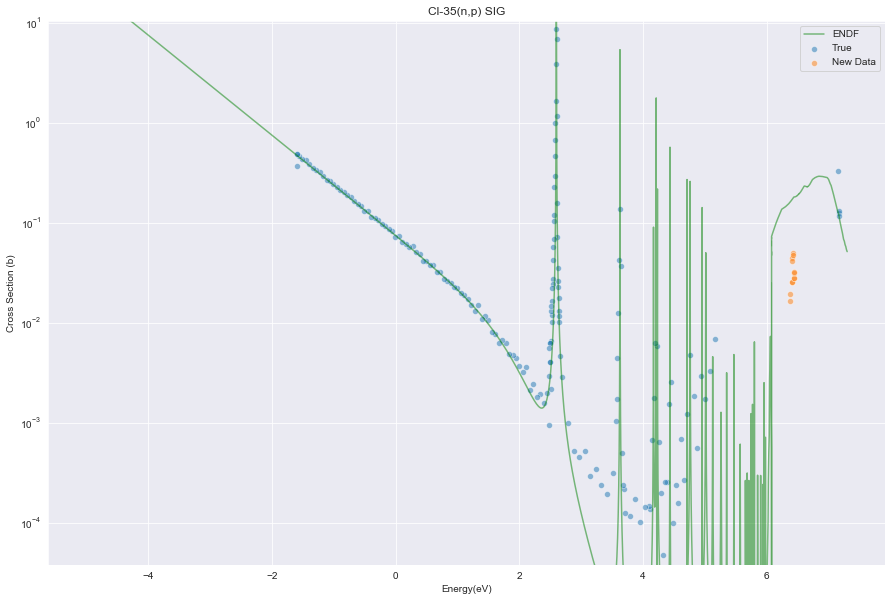

In [85]:
plot_exfor_endf(17, 35, "MT_103", endf_all)

In [86]:
def plot_exfor(MT, Z, M, nat_iso="I", additional_data=pd.DataFrame(), endf=pd.DataFrame(), df=df, save=False, interpolate=False, legend=True, alpha=0.7):
    # Extracting dataframe to make predictions and creating copy for evaluation
    to_plot = df[(df["Target_Protons"] == Z) & (df["MT"] == MT) & (df["Target_Mass_Number"] == M) & (df["Flag"] == nat_iso)].sort_values(
        by='Energy', ascending=False)
        
    # Initializing Figure and Plotting 
    plt.figure(figsize=(16,10))
    fg = sns.FacetGrid(data=to_plot[["Energy", "Data", "Reference"]], hue='Reference', hue_order=to_plot["Reference"].unique(), aspect=1.5, legend_out=False, height=10)
    fg.map(plt.scatter, "Energy", "Data", alpha=alpha)
    if legend == True:
        fg.add_legend()
    if interpolate == True:
        sns.lineplot(to_plot["Energy"], to_plot["Data"], alpha=alpha*0.5, label="Interpolation")
    if endf.shape[0] != 0:
        sns.lineplot(endf["Energy"], endf["Data"], c="g", label="ENDF", alpha=alpha*0.5)
    if additional_data.shape[0] != 0:
        sns.scatterplot(additional_data["Energy"], additional_data["Data"], alpha=0.5, label="New Data")
        
    plt.title("Z = {}, A = {}, MT = {}".format(Z, M, MT))
    plt.xlabel('log[Energy(eV)]')
    plt.ylabel('log[Cross Section (b)]')
    plt.yscale('log')
    
    if (additional_data.shape[0] != 0 and endf.shape[0] != 0): #if both 
        all_y = np.concatenate((to_plot["Data"], endf["Data"], additional_data["Data"]))
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    elif additional_data.shape[0] == 0 and endf.shape[0] !=0: # if ENDF only
        all_y = np.concatenate((to_plot["Data"], endf["Data"]))
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    elif additional_data.shape[0] != 0 and endf.shape[0] == 0: # if ADDITIONAL only
        all_y = np.concatenate((to_plot["Data"].values, additional_data["Data"].values))
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    else: # if no ENDF and Additional  
        all_y = to_plot["Data"].values
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    if save == True:
        plt.savefig(figure_dir + "EXFOR_{}_XS.png".format(to_plot.Element_w_A.values[0]))

C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\seaborn\relational.py:784: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\seaborn\relational.py:795: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


<Figure size 1152x720 with 0 Axes>

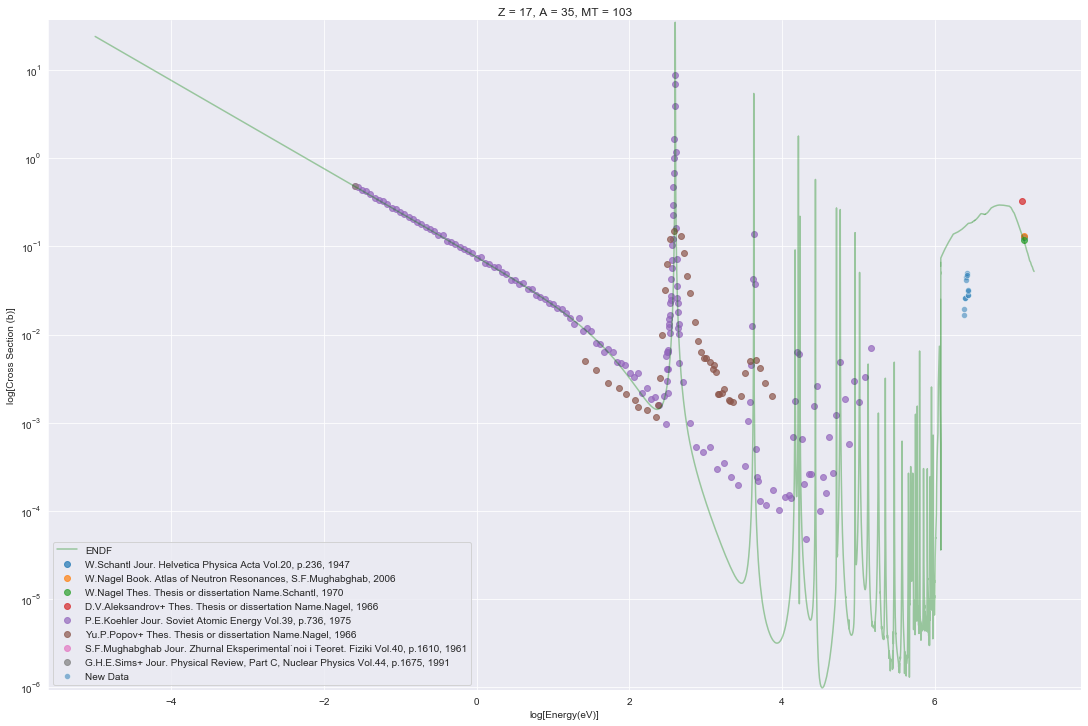

In [87]:
plot_exfor(103, 17, 35, additional_data=new_data, endf=endf_all, df=df_plotting, save=False)

# Evaluating Predictions

Two very important measures that are often used in Statistics to determine the accuracy of a model are:

> **R^2 / R-squared**:  also known as the coefficient of determination, is a measure to indicate how close the data is to the fitted regression line. The value of the R-squared is the percentage of variation of the response variable (y) that is explained by a linear model.

> **Mean Squared Error (MSE)**: measures the average of the squares of errors, that is, the difference between actual value (y) and the estimated value (ŷ).
 

In [88]:
from sklearn.metrics import mean_squared_error, r2_score

# Creating Training, Validation, and Testing Datasets

In [97]:
df = df[df.Energy != df.Energy.min()]

In [126]:
from sklearn.model_selection import train_test_split

In [127]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(["Data", "dData"], axis=1), df["Data"], test_size=0.20, random_state=0)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=0)

# Data Standarization 

For DT, normalization does not matter generally. However, for other algorithms like simple/multiple linear regression, neural networks, and k-clustering magnitudes of different features can create unexpected biases towards features with larger magnitudes.

In [128]:
from sklearn import preprocessing

In [129]:
# Specify columns to scale
to_scale = list(x_train.columns)[:66]
scaler = preprocessing.StandardScaler().fit(x_train[to_scale])
energy_scaler = preprocessing.StandardScaler().fit(x_train[["Energy"]])

In [130]:
x_train[to_scale] = scaler.transform(x_train[to_scale])
# x_val[to_scale] = scaler.transform(x_val[to_scale])
x_test[to_scale] = scaler.transform(x_test[to_scale])

# Prediction and Plotting Function

The following functions will be used to easily use the traine model to visualize the results on a particular isotope with a specific reaction type. 

In [131]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    ''' Flexibly plot a univariate distribution of observations. '''
    plt.figure(figsize=(12, 10))
    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)
    plt.yscale('log')
    plt.xscale('log')
    plt.title(Title)
    plt.xlabel('Cross Section (b)')
    plt.ylabel('Proportion of Data')
    plt.show()

In [164]:
def predicting_nuclear_xs(MT, Z, M, clf, additional_data=pd.DataFrame(), endf=pd.DataFrame(), E_min=0, E_max=0, N=0):
    ''' 
    Used to plot predictions of the clf model for specific isotope (Z, M) and runs.
    MT is the reaction type (e.g 1 is total cross section)
    E_min and E_max are the energy region in which to make additional inferences.
    '''
    # Extracting dataframe to make predictions and creating copy for evaluation
    to_infer = df[(df["Target_Protons"] == Z) & (df[MT] == 1) & (df["Target_Mass_Number"] == M)].sort_values(
        by='Energy', ascending=True)
    to_plot = to_infer.copy().sort_values(by='Energy', ascending=True)
    to_infer = to_infer.drop(columns=["Data", "dData"])

    if N != 0:
        energy_range = np.linspace(np.log10(1E6*E_min), np.log10(E_max*1E6), N)
        to_infer2 = pd.DataFrame({"Energy": energy_range})
        for i in list(to_infer.columns)[1:]:
            to_infer2[i] = to_infer[i].values[1]
        to_infer = to_infer.append(to_infer2, ignore_index=True).sort_values(by='Energy', ascending=True)

    # Applying standard scaler method 
    to_infer[to_scale] = scaler.transform(to_infer[to_scale])
    to_plot[to_scale] = scaler.transform(to_plot[to_scale])
    
    # Making Prediction with given model
    y_hat  = clf.predict(to_infer)
    y_hat2 = clf.predict(to_plot.drop(columns=["Data", "dData"]))
    
    # Returning features to original values for plotting
    to_infer[to_scale] = scaler.inverse_transform(to_infer[to_scale])
    to_plot[to_scale] = scaler.inverse_transform(to_plot[to_scale])
        
    # Initializing Figure and Plotting 
    plt.figure(figsize=(16,10))
    if endf.shape[0] != 0:
        endf_eval = plt.plot(endf["Energy"], endf["Data"], alpha=0.3, c="g")
    true = plt.scatter(to_plot["Energy"], to_plot["Data"], alpha=0.3, c='b')
    pred = plt.scatter(to_infer["Energy"], y_hat, alpha=0.5, c="orange")

    if additional_data.shape[0] != 0:
        additional_data[to_scale] = scaler.transform(additional_data[to_scale])
        y_hat3 = clf.predict(additional_data.drop(columns=["Data", "dData"]))
        additional_data[to_scale] = scaler.inverse_transform(additional_data[to_scale])
        unseen = plt.scatter(additional_data["Energy"], additional_data["Data"], alpha=0.3, c="b")
        pred_unseen = plt.scatter(additional_data["Energy"], y_hat3, alpha=0.5, c="r")
    plt.yscale('log')
    plt.title('Cross Section Inference ' + MT)
    plt.xlabel('Log10 Energy(MeV)')
    plt.ylabel('Cross Section (b)')
    if (additional_data.shape[0] != 0 and endf.shape[0] != 0): #if both 
        plt.legend((endf_eval, true, unseen, pred, pred_unseen),
                   ('ENDF', 'EXFOR', "New Measurments", "EXFOR Pred", "New Pred"), loc='upper left')
        all_y = np.concatenate((to_plot["Data"], y_hat, y_hat2, endf["Data"], additional_data["Data"], y_hat3))
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    elif additional_data.shape[0] == 0 and endf.shape[0] !=0: # if ENDF only
        plt.legend((endf_eval, true, pred), ('ENDF', 'EXFOR', "EXFOR Pred"), loc='upper left')
        all_y = np.concatenate((to_plot["Data"], y_hat, y_hat2, endf["Data"]))
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    elif additional_data.shape[0] != 0 and endf.shape[0] == 0: # if ADDITIONAL only
        plt.legend((true, unseen, pred, pred_unseen), 
                   ('EXFOR', "New Measurments", "EXFOR Pred", "New Pred"), loc='upper left')
        all_y = np.concatenate((to_plot["Data"].values, y_hat, y_hat2, additional_data["Data"].values, y_hat3))
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    else: # if no ENDF and Additional
        plt.legend((true, pred), ('EXFOR', "EXFOR Pred"), loc='upper left')    
        all_y = np.concatenate((to_plot["Data"], y_hat, y_hat2))
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    plt.show()
    
    
    # Initializing Figure and Plotting
    if additional_data.shape[0] != 0:
        plt.figure(figsize=(16,10))
        pred_unseen = plt.scatter(additional_data["Energy"], y_hat3, alpha=0.5, c="orange")
        # unseen = plt.scatter(new_data["Energy"], new_data["Data"], alpha=0.5, label="New Data True", c="r")  
        unseen = plt.errorbar(additional_data["Energy"], additional_data["Data"], yerr=additional_data["dData"], c='b', fmt='o', alpha=0.3)
        if endf.shape[0] != 0:
            endf_data = plt.plot(endf['Energy'], endf["Data"], c="g", alpha=0.3)
        plt.title('Cross Section Inference ' + MT)
        plt.xlabel('Log10 Energy(MeV)')
        plt.ylabel('Cross Section (b)')
        minimum_x = additional_data["Energy"].min() - additional_data["Energy"].min() * 0.001
        maximum_x = additional_data["Energy"].max() + additional_data["Energy"].max() * 0.001
        plt.xlim(minimum_x, maximum_x)
        plt.yscale('log')
        if endf.shape[0] != 0:
            plt.legend((pred_unseen, unseen, endf_data), ("New Pred", "New", "ENDF"), loc='upper left')
            all_y = np.concatenate((additional_data["Data"].values,
                                    endf[(endf['Energy'] >= minimum_x) & (endf['Energy'] <= maximum_x)]["Data"].values,
                                    y_hat3))
            minimum_y = all_y.min() - all_y.min() * 0.05
            maximum_y = all_y.max() + all_y.max() * 0.05
            plt.ylim(minimum_y, maximum_y)
        else:
            plt.legend((pred_unseen, unseen), ("New Pred", "New"), loc='upper left')
            all_y = np.concatenate((additional_data["Data"].values, y_hat3))
            minimum_y = all_y.min() - all_y.min() * 0.05
            maximum_y = all_y.max() + all_y.max() * 0.05
            plt.ylim(minimum_y, maximum_y)
        plt.show()
        
    if endf.shape[0] != 0:
        endf_all_int = endf.copy()
        to_plot2 = to_plot.copy()
        indexes = np.arange(len(endf), len(endf) + len(to_plot2))
        to_plot2.index = indexes
        energy_interest = to_plot2[["Energy"]]
        energy_interest["Data"] = np.nan
        endf_all_int = endf_all_int.append(energy_interest, ignore_index=False)
        endf_all_int = endf_all_int.sort_values(by=['Energy'])
        endf_all_int["Data"] = endf_all_int["Data"].interpolate()

        # Measuring metrics on predictions.
        print("ENDF vs EXFOR:")
        print("The MSE is: ", mean_squared_error(to_plot2["Data"], endf_all_int[["Data"]].loc[indexes]))
        print("The R2-Score is: ", r2_score(to_plot2["Data"], endf_all_int[["Data"]].loc[indexes]))
    
    # Measuring metrics on predictions.
    print("XS Tree vs EXFOR:")
    print("The MSE is: ", mean_squared_error(to_plot["Data"], y_hat2))
    print("The R2-Score is: ", r2_score(to_plot["Data"], y_hat2))

In [166]:
def predicting_nuclear_xs(MT, Z, M, clf, additional_data=pd.DataFrame(), endf=pd.DataFrame(), E_min=0, E_max=0, N=0):
    ''' 
    Used to plot predictions of the clf model for specific isotope (Z, M) and runs.
    MT is the reaction type (e.g 1 is total cross section)
    E_min and E_max are the energy region in which to make additional inferences.
    '''
    # Extracting dataframe to make predictions and creating copy for evaluation
    to_infer = df[(df["Target_Protons"] == Z) & (df[MT] == 1) & (df["Target_Mass_Number"] == M)].sort_values(
        by='Energy', ascending=True)
    to_plot = to_infer.copy().sort_values(by='Energy', ascending=True)
    to_infer = to_infer.drop(columns=["Data", "dData"])

    if N != 0:
        energy_range = np.linspace(np.log10(1E6*E_min), np.log10(E_max*1E6), N)
        to_infer2 = pd.DataFrame({"Energy": energy_range})
        for i in list(to_infer.columns)[1:]:
            to_infer2[i] = to_infer[i].values[1]
        to_infer = to_infer.append(to_infer2, ignore_index=True).sort_values(by='Energy', ascending=True)

    
    # Applying standard scaler method 
    to_infer[to_scale] = scaler.transform(to_infer[to_scale])
    to_plot[to_scale] = scaler.transform(to_plot[to_scale])
    
    # Making Prediction with given model
    y_hat  = clf.predict(to_infer)
    y_hat2 = clf.predict(to_plot.drop(columns=["Data", "dData"]))
    
    # Returning features to original values for plotting
    to_infer[to_scale] = scaler.inverse_transform(to_infer[to_scale])
    to_plot[to_scale] = scaler.inverse_transform(to_plot[to_scale])
        
    # Initializing Figure and Plotting 
    plt.figure(figsize=(16,10))
    if endf.shape[0] != 0:
        endf_eval = plt.plot(endf["Energy"], endf["Data"], alpha=0.3, c="g")
    true = plt.scatter(to_plot["Energy"], to_plot["Data"], alpha=0.3, c='b')
    pred = plt.scatter(to_infer["Energy"], y_hat, alpha=0.5, c="orange")

    if additional_data.shape[0] != 0:
        additional_data[to_scale] = scaler.transform(additional_data[to_scale])
        y_hat3 = clf.predict(additional_data.drop(columns=["Data", "dData"]))
        additional_data[to_scale] = scaler.inverse_transform(additional_data[to_scale])
        unseen = plt.scatter(additional_data["Energy"], additional_data["Data"], alpha=0.3, c="b")
        pred_unseen = plt.scatter(additional_data["Energy"], y_hat3, alpha=0.5, c="r")
    plt.yscale('log')
    plt.title('Cross Section Inference ' + MT)
    plt.xlabel('Log10 Energy(MeV)')
    plt.ylabel('Cross Section (b)')
    if (additional_data.shape[0] != 0 and endf.shape[0] != 0): #if both 
        plt.legend((endf_eval, true, unseen, pred, pred_unseen),
                   ('ENDF', 'EXFOR', "New Measurments", "EXFOR Pred", "New Pred"), loc='upper left')
        # all_y = np.concatenate((to_plot["Data"], y_hat[0], y_hat2[0], endf["Data"], additional_data["Data"], y_hat3[0]))
        all_y = np.concatenate((to_plot["Data"].values.flatten(), y_hat[0].flatten(), y_hat2[0].flatten(), endf["Data"].values.flatten(), additional_data["Data"].values.flatten(), y_hat3[0].flatten()))
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    elif additional_data.shape[0] == 0 and endf.shape[0] !=0: # if ENDF only
        plt.legend((endf_eval, true, pred), ('ENDF', 'EXFOR', "EXFOR Pred"), loc='upper left')
        all_y = np.concatenate((to_plot["Data"], y_hat, y_hat2, endf["Data"]))
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    elif additional_data.shape[0] != 0 and endf.shape[0] == 0: # if ADDITIONAL only
        plt.legend((true, unseen, pred, pred_unseen), 
                   ('EXFOR', "New Measurments", "EXFOR Pred", "New Pred"), loc='upper left')
        all_y = np.concatenate((to_plot["Data"].values, y_hat, y_hat2, additional_data["Data"].values, y_hat3))
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    else: # if no ENDF and Additional
        plt.legend((true, pred), ('EXFOR', "EXFOR Pred"), loc='upper left')    
        all_y = np.concatenate((to_plot["Data"], y_hat, y_hat2))
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    plt.show()
    
    
    # Initializing Figure and Plotting
    if additional_data.shape[0] != 0:
        plt.figure(figsize=(16,10))
        pred_unseen = plt.scatter(additional_data["Energy"], y_hat3, alpha=0.5, c="orange")
        unseen = plt.scatter(new_data["Energy"], new_data["Data"], alpha=0.3, c="b")  
        # unseen = plt.errorbar(additional_data["Energy"], additional_data["Data"], yerr=additional_data["dData"], c='b', fmt='o', alpha=0.3)
        if endf.shape[0] != 0:
            endf_data = plt.plot(endf['Energy'], endf["Data"], c="g", alpha=0.3)
        plt.title('Cross Section Inference ' + MT)
        plt.xlabel('Log10 Energy(MeV)')
        plt.ylabel('Cross Section (b)')
        minimum_x = additional_data["Energy"].min() - additional_data["Energy"].min() * 0.001
        maximum_x = additional_data["Energy"].max() + additional_data["Energy"].max() * 0.001
        plt.xlim(minimum_x, maximum_x)
        plt.yscale('log')
        if endf.shape[0] != 0:
            plt.legend((pred_unseen, unseen, endf_data), ("New Pred", "New", "ENDF"), loc='upper left')
            all_y = np.concatenate((additional_data["Data"].values,
                                    endf[(endf['Energy'] >= minimum_x) & (endf['Energy'] <= maximum_x)]["Data"].values,
                                    y_hat3[0].flatten()))
            print(y_hat3)
            minimum_y = all_y.min() - all_y.min() * 0.05
            maximum_y = all_y.max() + all_y.max() * 0.05
            plt.ylim(minimum_y, maximum_y)
        else:
            plt.legend((pred_unseen, unseen), ("New Pred", "New"), loc='upper left')
            all_y = np.concatenate((additional_data["Data"].values, y_hat3))
            minimum_y = all_y.min() - all_y.min() * 0.05
            maximum_y = all_y.max() + all_y.max() * 0.05
            plt.ylim(minimum_y, maximum_y)
        plt.show()
        
    if endf.shape[0] != 0:
        endf_all_int = endf.copy()
        to_plot2 = to_plot.copy()
        indexes = np.arange(len(endf), len(endf) + len(to_plot2))
        to_plot2.index = indexes
        energy_interest = to_plot2[["Energy"]]
        energy_interest["Data"] = np.nan
        endf_all_int = endf_all_int.append(energy_interest, ignore_index=False)
        endf_all_int = endf_all_int.sort_values(by=['Energy'])
        endf_all_int["Data"] = endf_all_int["Data"].interpolate()

        # Measuring metrics on predictions.
        print("ENDF vs EXFOR:")
        print("The MSE is: ", mean_squared_error(to_plot2["Data"], endf_all_int[["Data"]].loc[indexes]))
        print("The R2-Score is: ", r2_score(to_plot2["Data"], endf_all_int[["Data"]].loc[indexes]))
    
    # Measuring metrics on predictions.
    print("XS Tree vs EXFOR:")
    print("The MSE is: ", mean_squared_error(to_plot["Data"], y_hat2))
    print("The R2-Score is: ", r2_score(to_plot["Data"], y_hat2))

In [136]:
def predicting_nuclear_xs_e(MT, Z, M, clf, scaler, E_min=0.01, E_max=475000):
    ''' 
    Used to plot predictions of the clf model for specific isotope (Z, M) and runs.
    MT is the reaction type (e.g 1 is total cross section)
    E_min and E_max are the energy region in which to make additional inferences.
    '''
    # --- Extracting dataframe to make predictions and
    #     Copying dataframe to apply model metrics 
    to_infer = df[(df["Target_Protons"] == Z) & (df[MT] == 1) & (df["Target_Mass_Number"] == M)][["Energy", "Data"]]
    to_plot = to_infer.copy().sort_values(by='Energy', ascending=True)
    
    # Dropping Data (XS) for inference
    # Creating additional points to plot based on energy range given
    energy_range = np.linspace(np.log10(1E6*E_min), np.log10(E_max*1E6), 100)
    to_infer = to_infer.drop(columns=["Data"]).append(pd.DataFrame({"Energy": energy_range}), ignore_index=True).sort_values(by='Energy', ascending=True)

    # Applying standard scaler method 
    to_infer["Energy"] = scaler.transform(to_infer[["Energy"]])
    to_plot["Energy"] = scaler.transform(to_plot[["Energy"]])
        
    # Making Prediction with given model
    y_hat  = clf.predict(to_infer)
    y_hat_2 = clf.predict(to_plot.drop(columns=["Data"]))
    
    # Returning features to original values for plotting
    to_infer[["Energy"]] = scaler.inverse_transform(to_infer[["Energy"]])
    to_plot[["Energy"]] = scaler.inverse_transform(to_plot[["Energy"]])

    # Initializing Figure and Plotting 
    plt.figure(figsize=(15,10))
    pred = plt.scatter(to_infer["Energy"], y_hat, alpha=0.5)
    true = plt.scatter(to_plot["Energy"], to_plot["Data"], alpha=0.3)
    
    unseen = plt.scatter(new_data["Energy"], new_data["Data"], alpha=0.5, label="New Data")
    
    plt.ylim(1E-5, 1.5E1)
    plt.yscale('log')
    plt.title('Cl-35 Cross Section ' + MT)
    plt.xlabel('Energy(eV)')
    plt.ylabel('Cross Section (b)')
    
    plt.legend((pred, true, unseen), ('Predicted', 'True', "New"), loc='upper left')
    
    plt.show()
    
    # Measuring metrics on predictions.
    print("The MSE is: ", mean_squared_error(to_plot["Data"], y_hat_2))
    print("The R2-Score is: ", r2_score(to_plot["Data"], y_hat_2))

# Decision Trees

We will try to fit a DT regressor with default parameters. 
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [137]:
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [138]:
# Chlorine for Training and Testing (Single Isotope)
x_cl = to_plot.drop(columns=["Data", "dData"])
x_cl[to_scale] = scaler.transform(x_cl[to_scale])
y_cl = to_plot["Data"]
x_cl_train, x_cl_test, y_cl_train, y_cl_test = train_test_split(x_cl, y_cl, test_size=0.20, random_state=0)

# Only Energy
x_cl_en = x_cl[["Energy"]]

We wil begin by training the model only using the chlorine 35 (n,p) dataset and the feature `Energy`.

The depth of the three is:  18


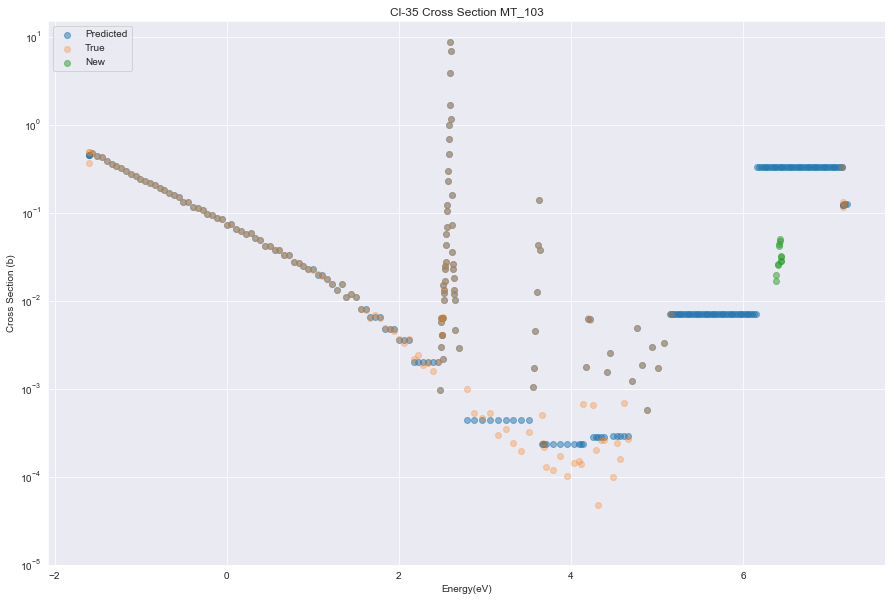

The MSE is:  5.515261034908624e-05
The R2-Score is:  0.9999321415812947


In [174]:
xs_tree_e = tree.DecisionTreeRegressor(max_depth=100)
xs_tree_e.fit(x_cl_en, y_cl)
print("The depth of the three is: ", xs_tree_e.get_depth())

y_hat_e = xs_tree_e.predict(x_cl_en)
# DistributionPlot(y_cl, y_hat_e, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs_e("MT_103", 17, 35, xs_tree_e, energy_scaler, E_min=0.14, E_max=16)

We will now use the same Chlorine data set but all the avaliable features.

The depth of the three is:  18


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000020C13926588>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


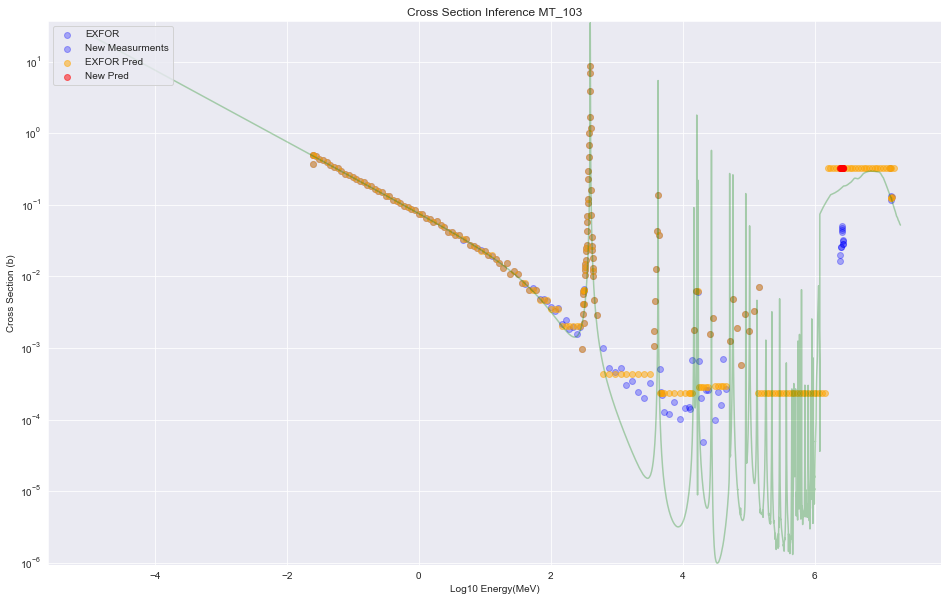

C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\ipykernel_launcher.py:96: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000020CD39AF988>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


[0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33]


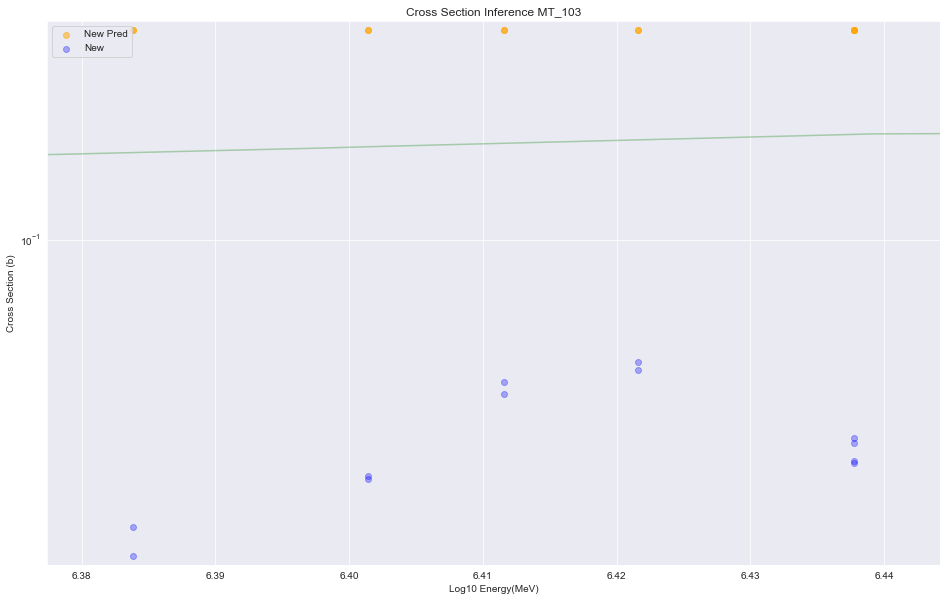

ENDF vs EXFOR:
The MSE is:  1.5254315355274362
The R2-Score is:  -0.8768535376442768
XS Tree vs EXFOR:
The MSE is:  5.822827960997266e-07
The R2-Score is:  0.999999283573533


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [173]:
xs_tree_cle = tree.DecisionTreeRegressor(max_depth=100)
xs_tree_cle.fit(x_cl, y_cl)
print("The depth of the three is: ", xs_tree_cle.get_depth())

# y_hat = xs_tree_cle.predict(x_cl)
# DistributionPlot(y_cl, y_hat, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs("MT_103", 17, 35, xs_tree_cle, additional_data=new_data, endf=endf_all, E_min=0.14, E_max=16, N=50)

We will now use the entire `EXFOR` dataset and all features.

C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000020C14B8F648>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


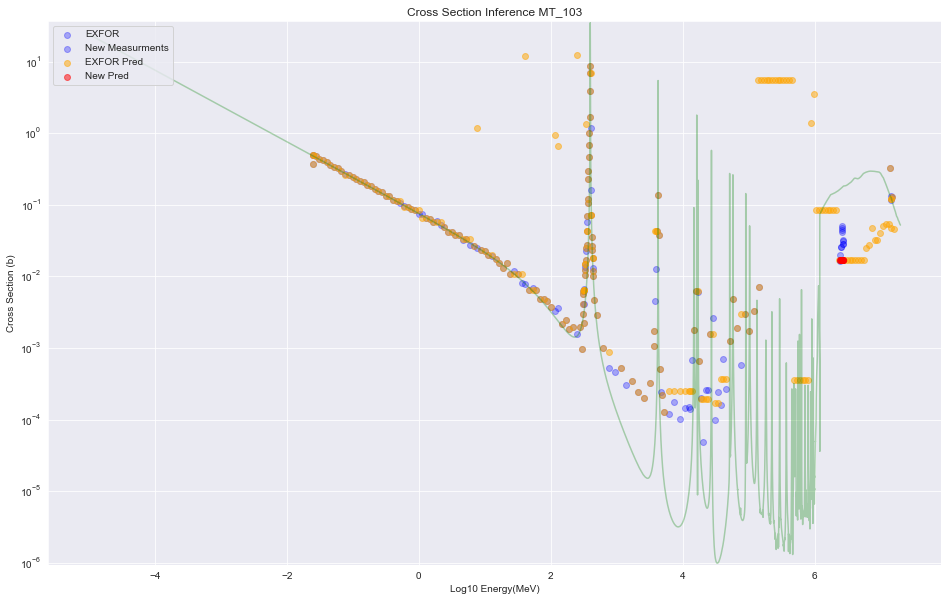

C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\ipykernel_launcher.py:96: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000021160E72148>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


[0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017]


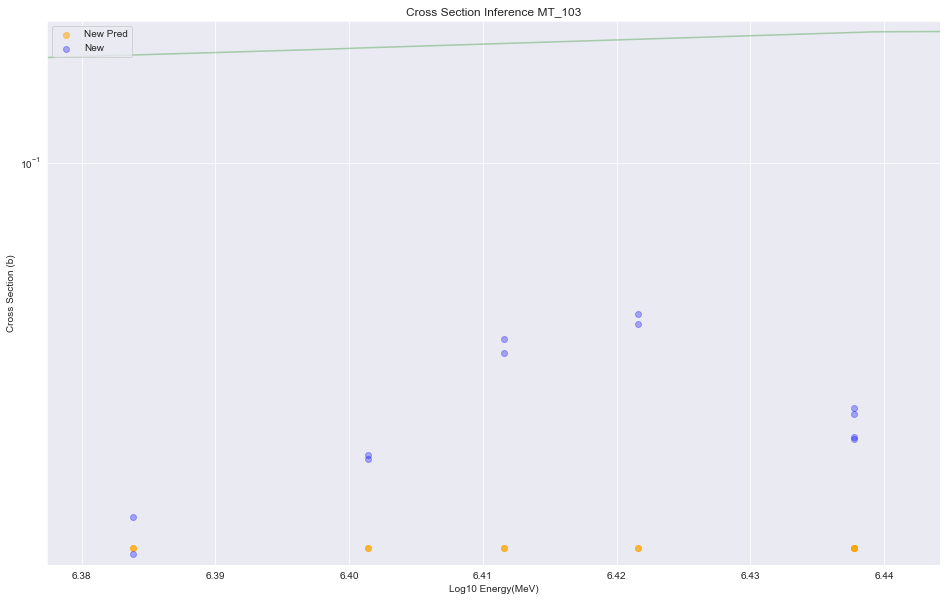

ENDF vs EXFOR:
The MSE is:  1.5254315355274362
The R2-Score is:  -0.8768535376442768
XS Tree vs EXFOR:
The MSE is:  1.9192791978204404
The R2-Score is:  -1.3614340389985826


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [197]:
# y_hat = xs_tree.predict(x_cl)
# DistributionPlot(y_cl, y_hat, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs("MT_103", 17, 35, xs_tree_cle, additional_data=new_data, endf=endf_all, E_min=0.14, E_max=16, N=50)

In [200]:
xs_tree_2 = tree.DecisionTreeRegressor(max_depth=150)
xs_tree_2.fit(x_train, y_train)
print("The depth of the three is: ", xs_tree_2.get_depth())

xs_test_pred = xs_tree_2.predict(x_test)
print("Testing MSE: ", mean_squared_error(xs_test_pred, y_test))
print("Testing R2-Score: ", r2_score(xs_test_pred, y_test))

The depth of the three is:  150
Testing MSE:  39541707399.60954
Testing R2-Score:  0.90344487010544


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000020CC3939108>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


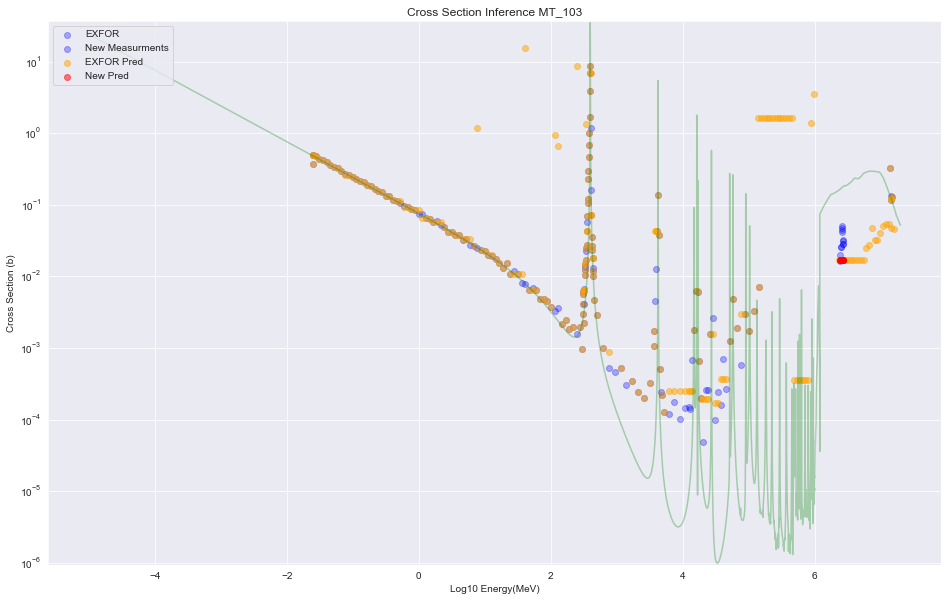

C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\ipykernel_launcher.py:96: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000020C14CF2108>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


[0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017]


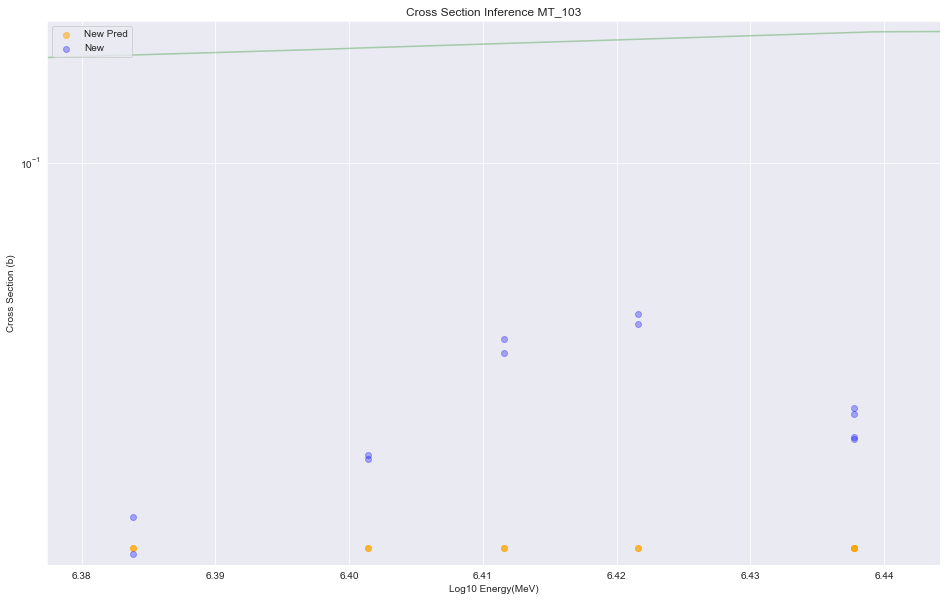

ENDF vs EXFOR:
The MSE is:  1.5254315355274362
The R2-Score is:  -0.8768535376442768
XS Tree vs EXFOR:
The MSE is:  2.0636273800169715
The R2-Score is:  -1.5390365010549387


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [201]:
predicting_nuclear_xs("MT_103", 17, 35, xs_tree_2, additional_data=new_data, endf=endf_all, E_min=0.14, E_max=16, N=50)

In [38]:
# dotfile = open("../ML_Data/dtree2.dot", 'w')
# tree.export_graphviz(xs_tree, out_file = dotfile, feature_names = x_train.columns)
# dotfile.close()

# AdaBoost Regressor

In [191]:
# from sklearn.ensemble import AdaBoostRegressor

# regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=200), random_state=0, n_estimators=100)
# regr.fit(x_train, y_train)

In [182]:
# regr.feature_importances_

# regr.score(x_test)

# xs_test_pred = xs_tree.predict(x_test)
# print("Testing MSE: ", mean_squared_error(xs_test_pred, y_test))
# print("Testing R2-Score: ", r2_score(xs_test_pred, y_test))

In [190]:
# predicting_nuclear_xs("MT_102", 92, 238, regr, additional_data=new_data, endf=endf_all, E_min=0.14, E_max=16, N=50)

# XGBoost

### Making Pipelines

Data Pipelines simplify the steps of processing the data. We use the module Pipeline to create a pipeline. We also use StandardScaler as a step in our pipeline.

In [ ]:
Input = [('polynomial', PolynomialFeatures(include_bias=False, degree=3)), 
         ('model', tree.DecisionTreeRegressor(max_depth=100))]
pipe = Pipeline(Input)
pipe.fit(x_cl, y_cl)
ypipe = pipe.predict(x_cl)

DistributionPlot(y_cl, ypipe, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs("MT_103", 17, 35, xs_tree, additional_data=new_data, endf=endf_all, E_min=0.14, E_max=16, N=50)

# Grid Search

In [292]:
from sklearn.model_selection import GridSearchCV
import pickle

In [291]:
DT_regressor = tree.DecisionTreeRegressor()
parameters = [{"criterion":["mse", "friedman_mse"], 'max_depth':[100, 125, 150, 200]}]
Grid1 = GridSearchCV(DT_regressor, parameters, cv=2, n_jobs=4, verbose=10)
Grid1.fit(df.drop(["Data", "dData"], axis=1), df["Data"])
BestRR1 = Grid1.best_estimator_

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  11 out of  16 | elapsed:  5.4min remaining:  2.4min
[Parallel(n_jobs=4)]: Done  13 out of  16 | elapsed:  6.9min remaining:  1.6min
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:  7.2min finished


In [293]:
BestRR1.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'max_depth': 150,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [ ]:
y_hat = BestRR1.predict(x_cl)
DistributionPlot(y_cl, y_hat, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs("MT_103", 17, 35, BestRR1, additional_data=new_data, endf=endf_all, E_min=0.14, E_max=16, N=50)

In [296]:
from joblib import dump, load
dump(BestRR1, '../ML_Data/Models/Decision_Trees/DT_GS.joblib') 

['../ML_Data/Models/Decision_Trees/DT_GS.joblib']

In [297]:
# clf = load('../ML_Data/Models/Decision_Trees/DT_GS.joblib') 

In [300]:
pd.DataFrame(Grid1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,105.628949,5.321785,2.972834,0.205371,mse,100,"{'criterion': 'mse', 'max_depth': 100}",-152595.947703,0.003221,-76297.972241,76297.975462,6
1,106.354232,5.810363,2.987142,0.160329,mse,125,"{'criterion': 'mse', 'max_depth': 125}",-130886.292096,0.003076,-65443.144510,65443.147586,5
2,99.040082,5.878277,2.809267,0.142550,mse,150,"{'criterion': 'mse', 'max_depth': 150}",-236120.410749,0.003213,-118060.203768,118060.206981,8
3,97.875131,6.295779,2.749046,0.062494,mse,200,"{'criterion': 'mse', 'max_depth': 200}",-97361.132363,0.003212,-48680.564575,48680.567787,2
4,97.830107,6.091568,2.813016,0.143266,friedman_mse,100,"{'criterion': 'friedman_mse', 'max_depth': 100}",-114877.160765,0.003068,-57438.578849,57438.581917,4
5,95.627638,6.216719,3.112856,0.159987,friedman_mse,125,"{'criterion': 'friedman_mse', 'max_depth': 125}",-100276.543571,0.003213,-50138.270179,50138.273392,3
6,98.321898,5.846999,2.747199,0.056655,friedman_mse,150,"{'criterion': 'friedman_mse', 'max_depth': 150}",-66674.846383,0.003213,-33337.421585,33337.424798,1
7,96.728994,6.824723,2.746037,0.041836,friedman_mse,200,"{'criterion': 'friedman_mse', 'max_depth': 200}",-204508.616966,0.003212,-102254.306877,102254.310089,7
